In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
# load previous data
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
arg_tors_trajs = list(np.load(f"{DATA_DIR}/raw_feat/arg_torsions.npy", allow_pickle=True))
arg_tors_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/arg_torsions_anton2.npy"))

In [13]:
# featurize new Anton trajectories
arg_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
for r in (217, 223, 226, 229, 232):
    arg_tors.add_sidechain_torsions(f"residue {r}", deg=False, which="all")
arg_tors.describe()

['CHI1 0 ARG 217',
 'CHI2 0 ARG 217',
 'CHI3 0 ARG 217',
 'CHI4 0 ARG 217',
 'CHI5 0 ARG 217',
 'CHI1 0 ARG 223',
 'CHI2 0 ARG 223',
 'CHI3 0 ARG 223',
 'CHI4 0 ARG 223',
 'CHI5 0 ARG 223',
 'CHI1 0 ARG 226',
 'CHI2 0 ARG 226',
 'CHI3 0 ARG 226',
 'CHI4 0 ARG 226',
 'CHI5 0 ARG 226',
 'CHI1 0 ARG 229',
 'CHI2 0 ARG 229',
 'CHI3 0 ARG 229',
 'CHI4 0 ARG 229',
 'CHI5 0 ARG 229',
 'CHI1 0 ARG 232',
 'CHI2 0 ARG 232',
 'CHI3 0 ARG 232',
 'CHI4 0 ARG 232',
 'CHI5 0 ARG 232']

In [14]:
# collect files
xtcs = []
for i in range(3, 119):
    if i == 82:
        continue
    xtcs.append(f"/project/dinner/scguo/ci-vsd/anton2/prot/civsd.prot.{i}.xtc")
anton_arg_tors = pyemma.coordinates.load(xtcs, features=arg_tors, chunksize=128)

Obtaining file info:   0%|          | 0/115 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/9085 [00:00<?, ?it/s]

In [15]:
np.save("../../data/raw_feat/arg_torsions_anton2.npy", anton_arg_tors)

In [7]:
arg_tors_trajs = list(np.load("../../../data/raw_feat/arg_torsions.npy", allow_pickle=True))
arg_tors_trajs.extend(np.load("../../../data/raw_feat/arg_torsions_anton2.npy"))

In [8]:
arg_tors_arr = np.rad2deg(np.concatenate(arg_tors_trajs))

In [9]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    0
]  # 0.1 ns lag time

In [10]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [11]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# S4 helix forward, backward committors for activation and deactivation

In [12]:
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights]

qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

# Violin plots of torsions

In [13]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [14]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.95)

In [15]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

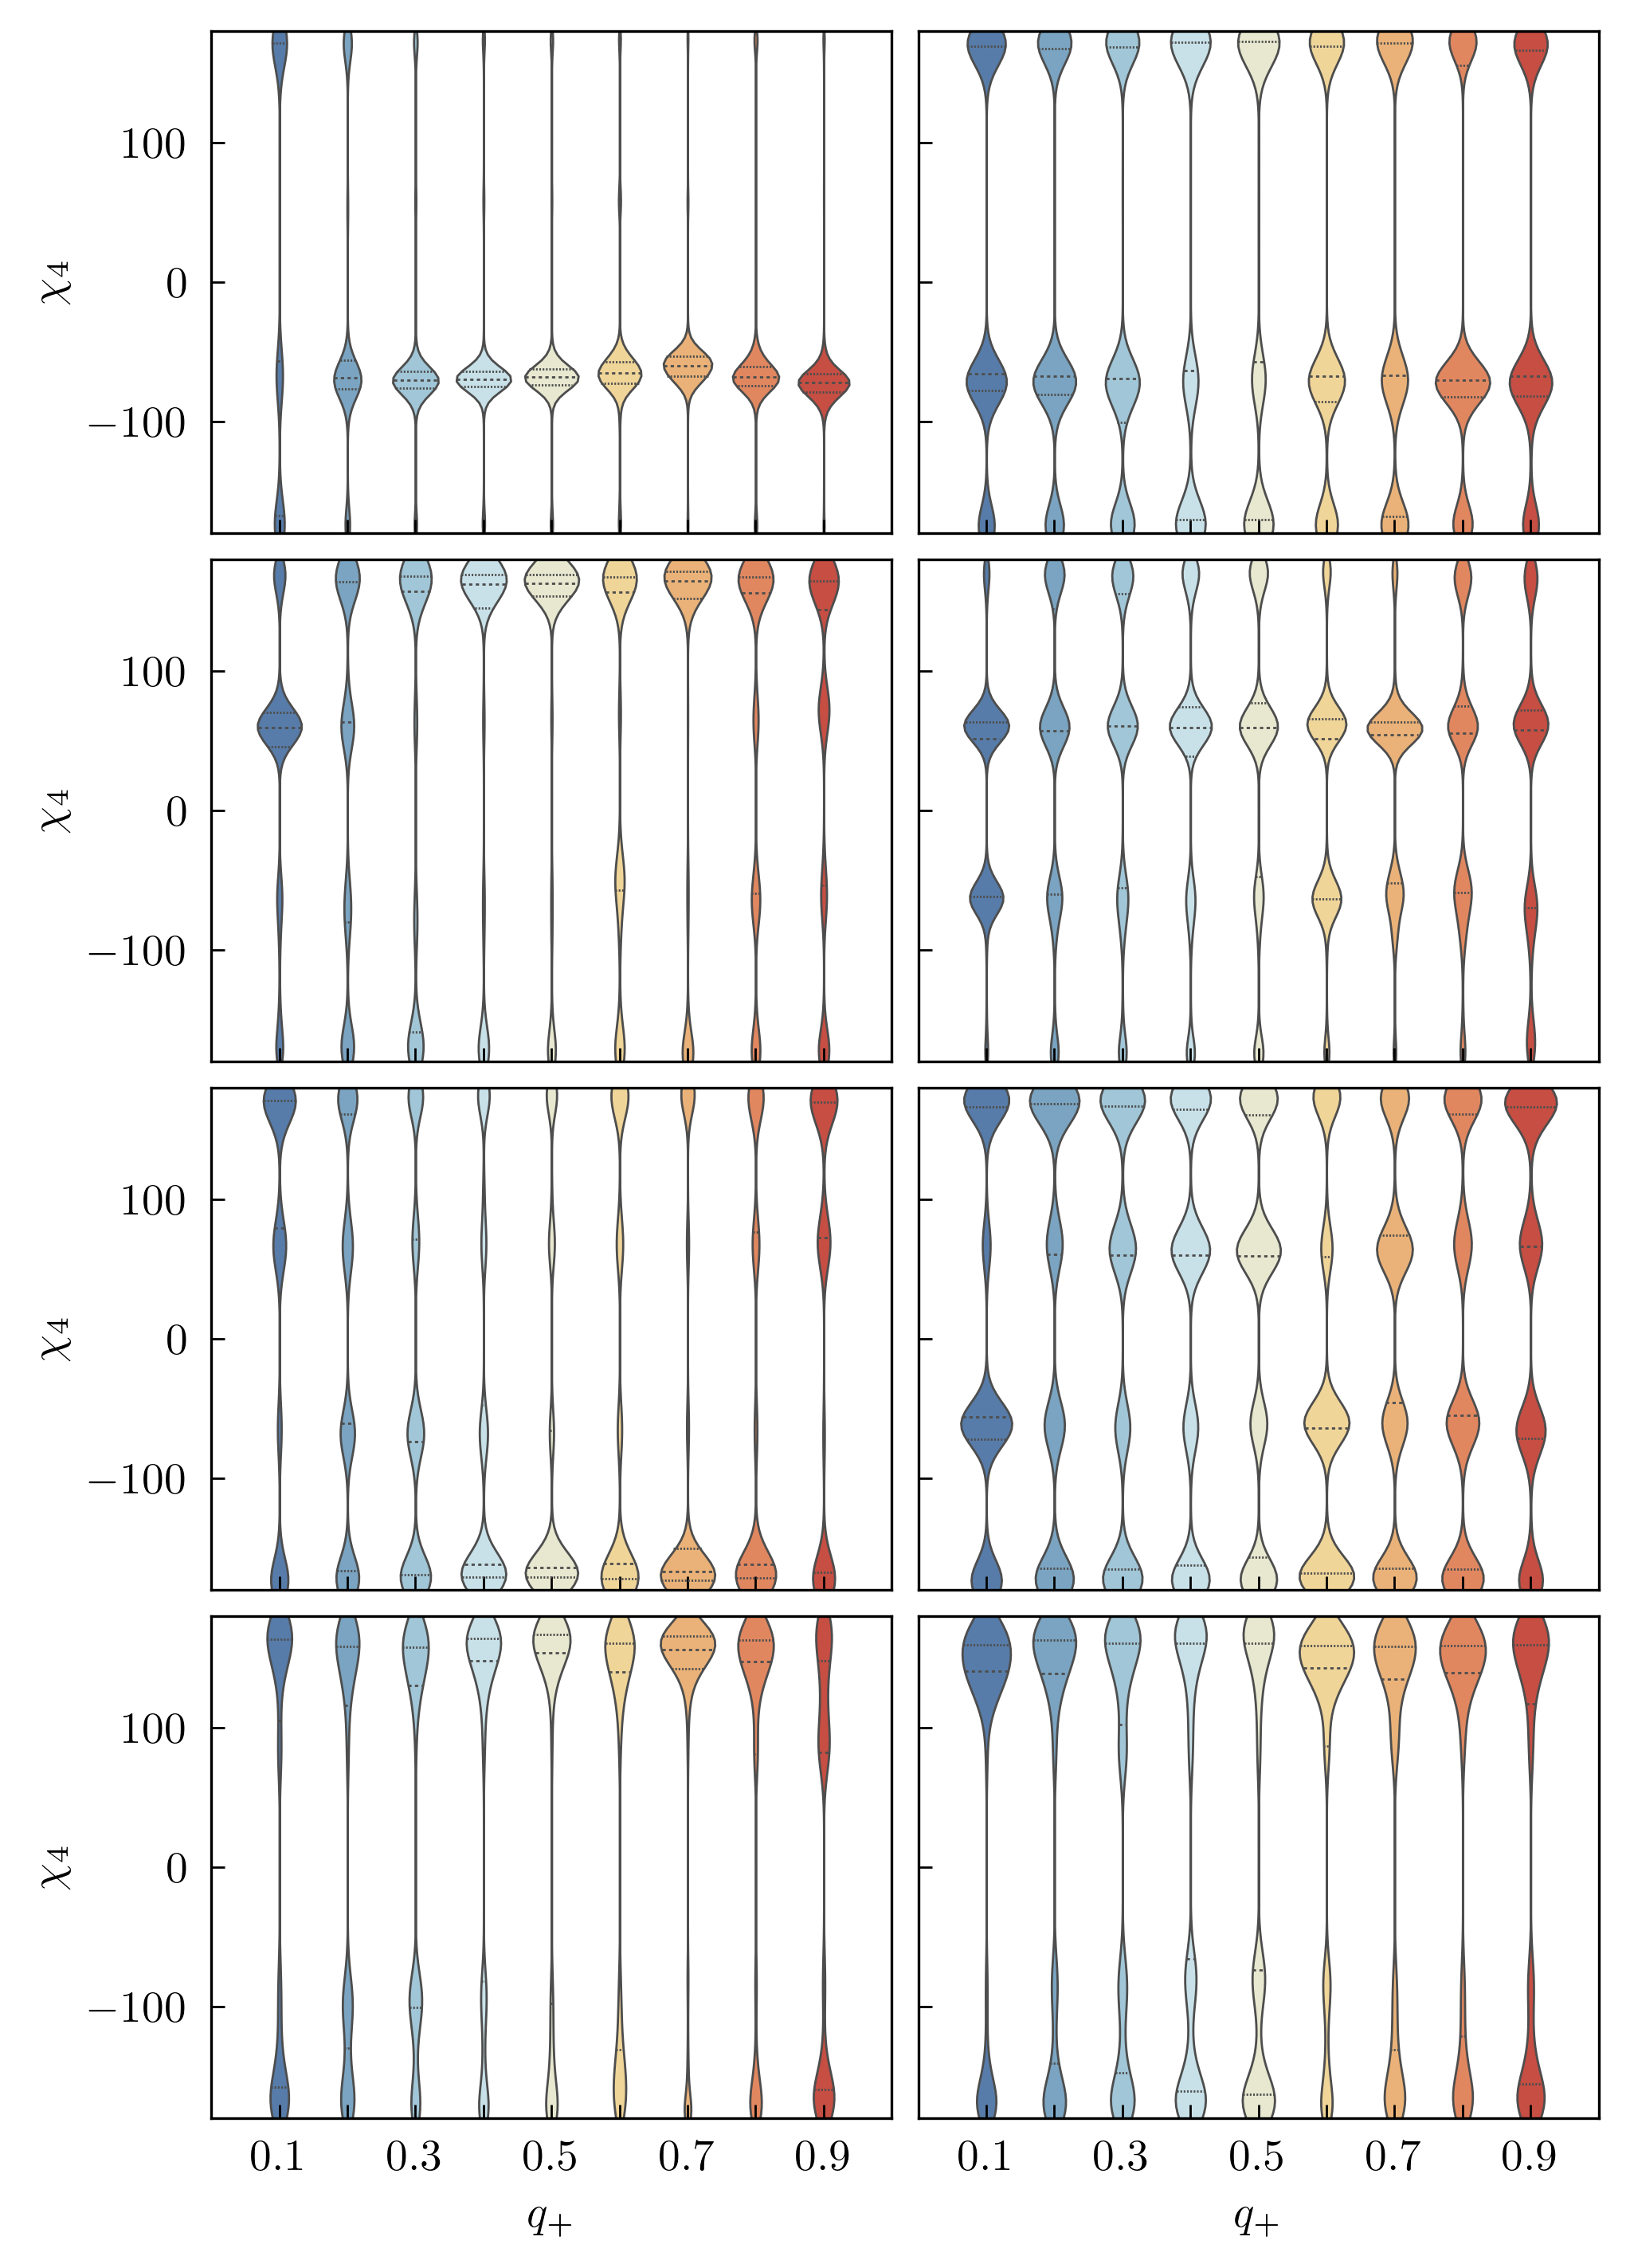

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(5, 7.0), dpi=200, constrained_layout=True, sharex=True)
for i, ax in enumerate(axes[:, 0]):
    # R226
    sns.violinplot(
        ax=ax,
        data=[arg_tors_arr[inds, i + 10] for inds in q_inds],
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        orient="v",
        linewidth=0.5,
    )
for i, ax in enumerate(axes[:, 1]):
    # R229
    sns.violinplot(
        ax=ax,
        data=[arg_tors_arr[inds, i + 15] for inds in q_inds],
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        orient="v",
        linewidth=0.5,
    )
for ax in axes.flat:
    ax.set_xticklabels(steplabels)
    ax.set_xlabel("$q_+$")
    ax.set_ylabel(f"$\\chi_{i + 1}$")
    ax.set_xlim([-1, 9])
    ax.set_ylim([-180, 180])
    ax.label_outer()

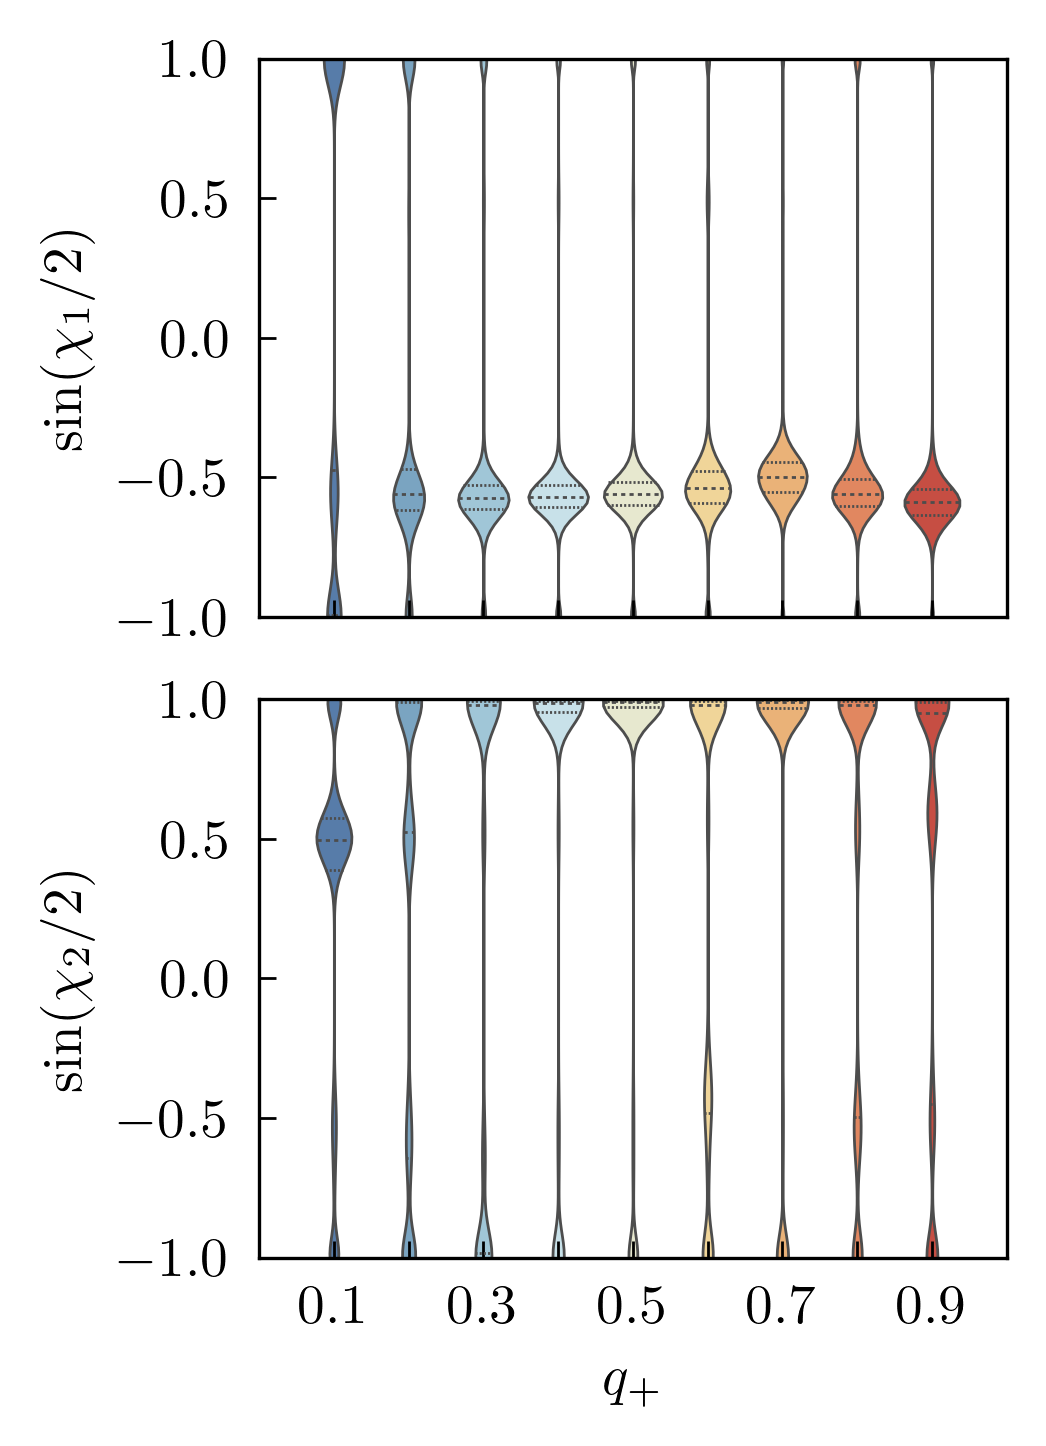

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(2.5, 3.5), dpi=200, constrained_layout=True, sharex=True)
for i, ax in enumerate(axes):
    # R226
    sns.violinplot(
        ax=ax,
        data=[np.sin(np.radians(arg_tors_arr) / 2)[inds, i + 10] for inds in q_inds],
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        orient="v",
        linewidth=0.5,
    )

    ax.set_xticklabels(steplabels)
    ax.set_xlabel("$q_+$")
    ax.set_ylabel(f"$\sin(\\chi_{i + 1} / 2)$")
    ax.set_xlim([-1, 9])
    ax.set_ylim([-1, 1])
    ax.label_outer()

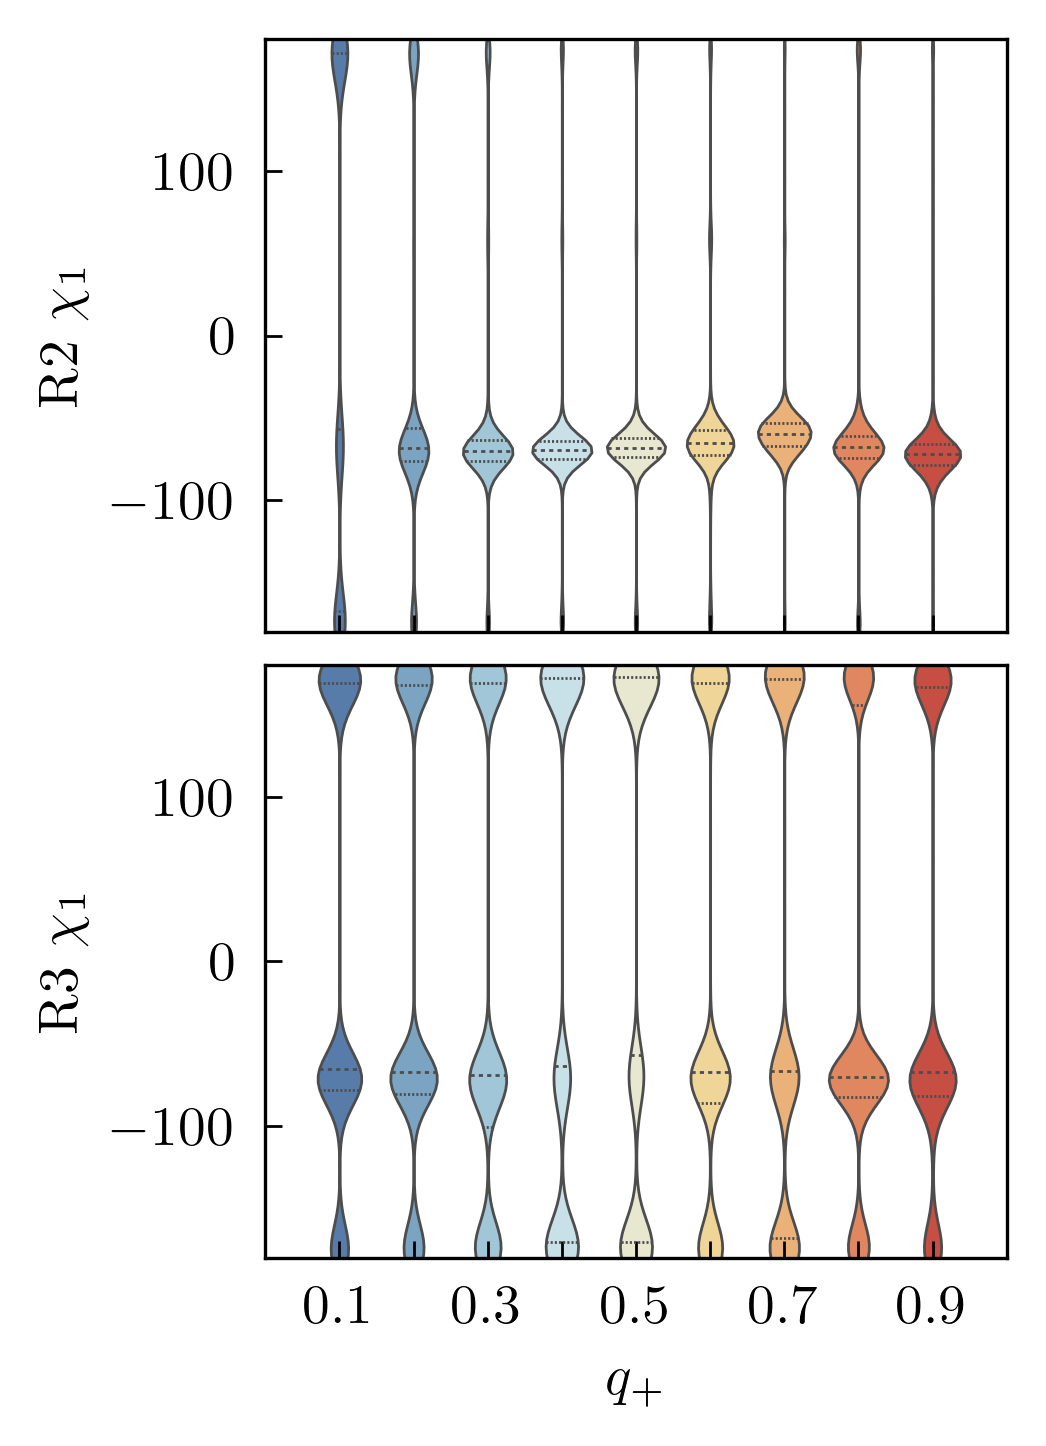

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(2.5, 3.5), dpi=200, constrained_layout=True, sharex=True)
rnames = ['R2', 'R3']
for i, ax in enumerate(axes):
    sns.violinplot(
        ax=ax,
        data=[arg_tors_arr[inds, (i + 2) * 5] for inds in q_inds],
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        orient="v",
        linewidth=0.5,
    )

    ax.set_xticklabels(steplabels)
    ax.set_xlabel("$q_+$")
    ax.set_ylabel(f"{rnames[i]} $\\chi_1$")
    ax.set_xlim([-1, 9])
    ax.set_ylim([-180, 180])
    ax.label_outer()

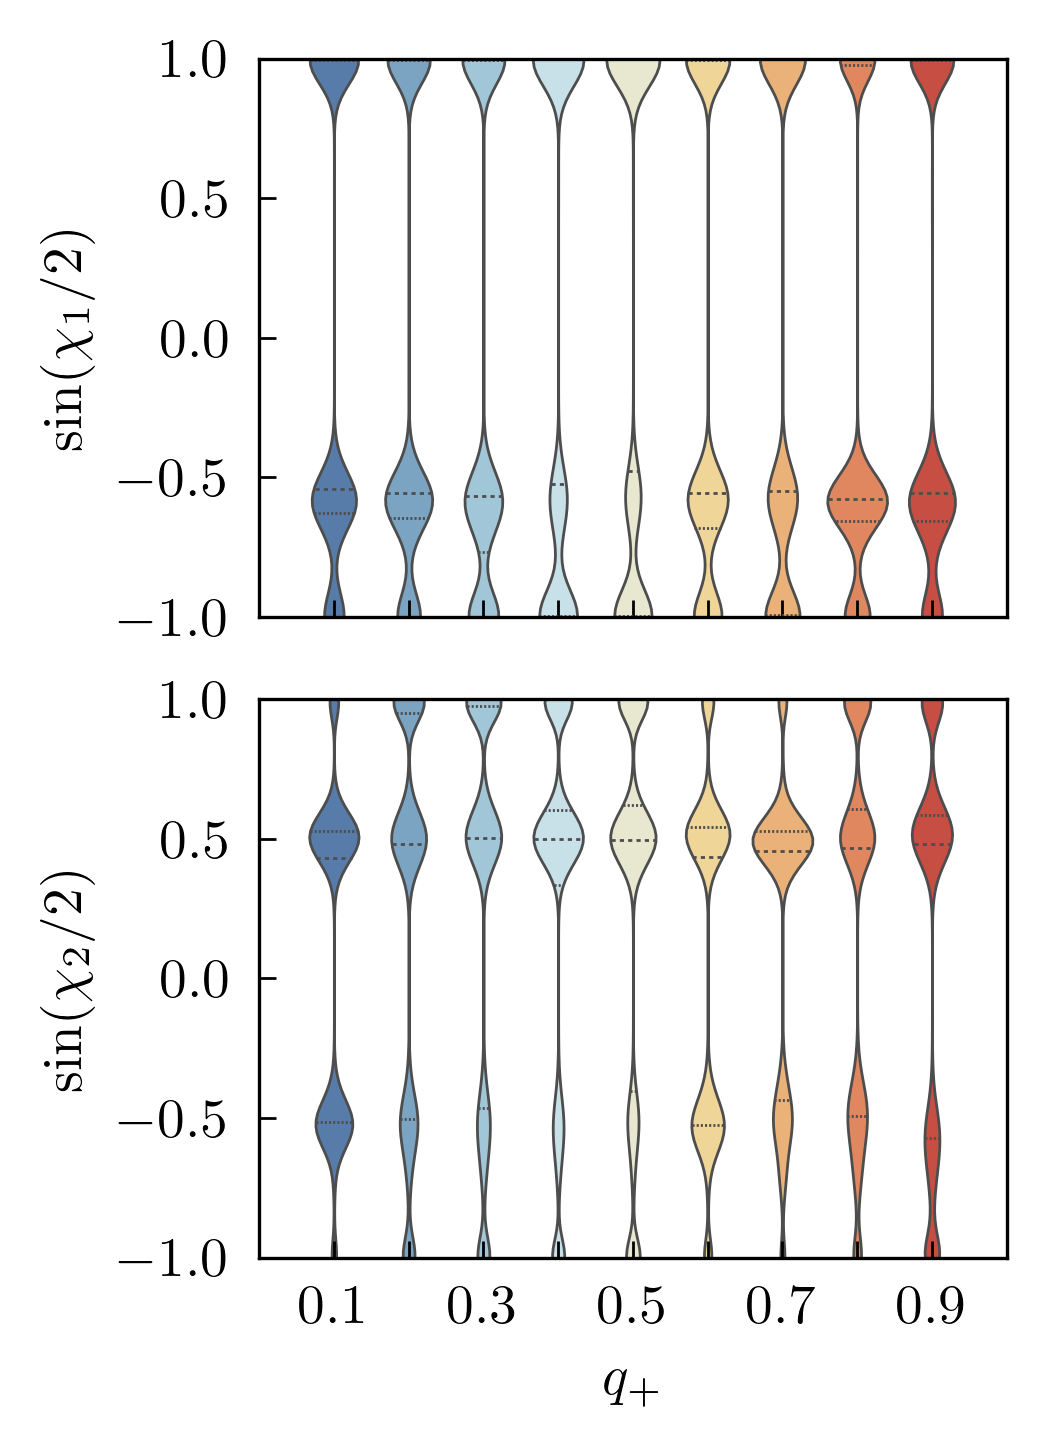

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(2.5, 3.5), dpi=200, constrained_layout=True, sharex=True)
for i, ax in enumerate(axes):
    # R229
    sns.violinplot(
        ax=ax,
        data=[np.sin(np.radians(arg_tors_arr) / 2)[inds, i + 15] for inds in q_inds],
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        orient="v",
        linewidth=0.5,
    )

    ax.set_xticklabels(steplabels)
    ax.set_xlabel("$q_+$")
    ax.set_ylabel(f"$\sin(\\chi_{i + 1} / 2)$")
    ax.set_xlim([-1, 9])
    ax.set_ylim([-1, 1])
    ax.label_outer()